# Projeto de Detecção de Fraude em Cartão de Crédito com PyTorch
## Projeto 1 para a disciplina PPGEEC2318
## Aluno: Israel da Silva Felix de Lima

In [ ]:
#Importando as bibliotecas necessárias

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
import glob
import os



In [93]:
# Definindo os estilo para as visualizações
plt.style.use('fivethirtyeight')

# Configuração do dispositivo no pytorch para rodar na GPU se disponível
# Caso não tenha GPU, o código rodará na CPU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo utilizado: {device}")

# Constantes
# Definindo o caminho para o dataset, tamanho do batch, taxa de aprendizado e número de épocas
DATASET_FOLDER_PATH = "dataset"
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 40

# Definição da função sigmoide para usar na avaliação
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Dispositivo utilizado: cpu



# 1. Análise Exploratória dos Dados


In [67]:
# Carregando os dados
def load_data():
    print('Lendo dados dos arquivos CSV')
    all_input_files = glob.glob(os.path.join(DATASET_FOLDER_PATH, "creditcard_part_*.csv"))
    df_list = [pd.read_csv(file) for file in all_input_files]
    df = pd.concat(df_list, ignore_index=True)
    df.columns = df.columns.str.lower()
    return df

df = load_data()

Lendo dados dos arquivos CSV


In [68]:
# Exibindo as primeiras linhas do dataframe
print("\nVisualização das primeiras 5 linhas dos dados:")
print(df.head())


Visualização das primeiras 5 linhas dos dados:
   time        v1        v2        v3        v4        v5        v6        v7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         v8        v9  ...       v21       v22       v23       v24       v25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.14126

In [69]:
# Informações do dataframe
print("\nInformações do dataframe:")
print(df.info())


Informações do dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-nu

In [70]:
# Estatísticas descritivas
print("\nEstatísticas descritivas:")
print(df.describe())


Estatísticas descritivas:
                time            v1            v2            v3            v4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 v5            v6            v7            v8            v9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247

In [71]:
# Verificando dados nulos
print("\nVerificando valores nulos no dataset:")
print(df.isnull().sum())


Verificando valores nulos no dataset:
time      0
v1        0
v2        0
v3        0
v4        0
v5        0
v6        0
v7        0
v8        0
v9        0
v10       0
v11       0
v12       0
v13       0
v14       0
v15       0
v16       0
v17       0
v18       0
v19       0
v20       0
v21       0
v22       0
v23       0
v24       0
v25       0
v26       0
v27       0
v28       0
amount    0
class     0
dtype: int64


In [72]:
# Distribuição das classes
print("\nDistribuição das classes (0 = Normal, 1 = Fraude):")
print(df['class'].value_counts())
print(f"Porcentagem de fraudes: {df['class'].mean() * 100:.2f}%")


Distribuição das classes (0 = Normal, 1 = Fraude):
class
0    284315
1       492
Name: count, dtype: int64
Porcentagem de fraudes: 0.17%


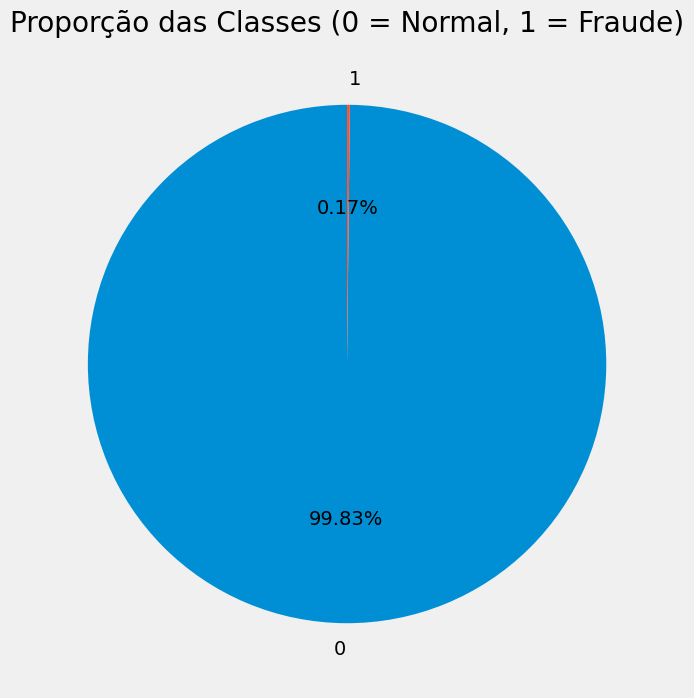

In [73]:
# Visualização em porcentagem como gráfico de pizza
plt.figure(figsize=(8, 8))
df['class'].value_counts(normalize=True).plot.pie(autopct='%1.2f%%', startangle=90)
plt.title('Proporção das Classes (0 = Normal, 1 = Fraude)')
plt.ylabel('')
plt.show()

In [74]:
# Identificar as features mais correlacionadas com fraudes
correlations_with_target = df.corr()['class'].sort_values(ascending=False)
print("Top 10 features mais correlacionadas com fraude:")
print(correlations_with_target.head(11))  # +1 porque uma delas é a própria 'class'

Top 10 features mais correlacionadas com fraude:
class     1.000000
v11       0.154876
v4        0.133447
v2        0.091289
v21       0.040413
v19       0.034783
v20       0.020090
v8        0.019875
v27       0.017580
v28       0.009536
amount    0.005632
Name: class, dtype: float64


c:\Users\israe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\israe\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


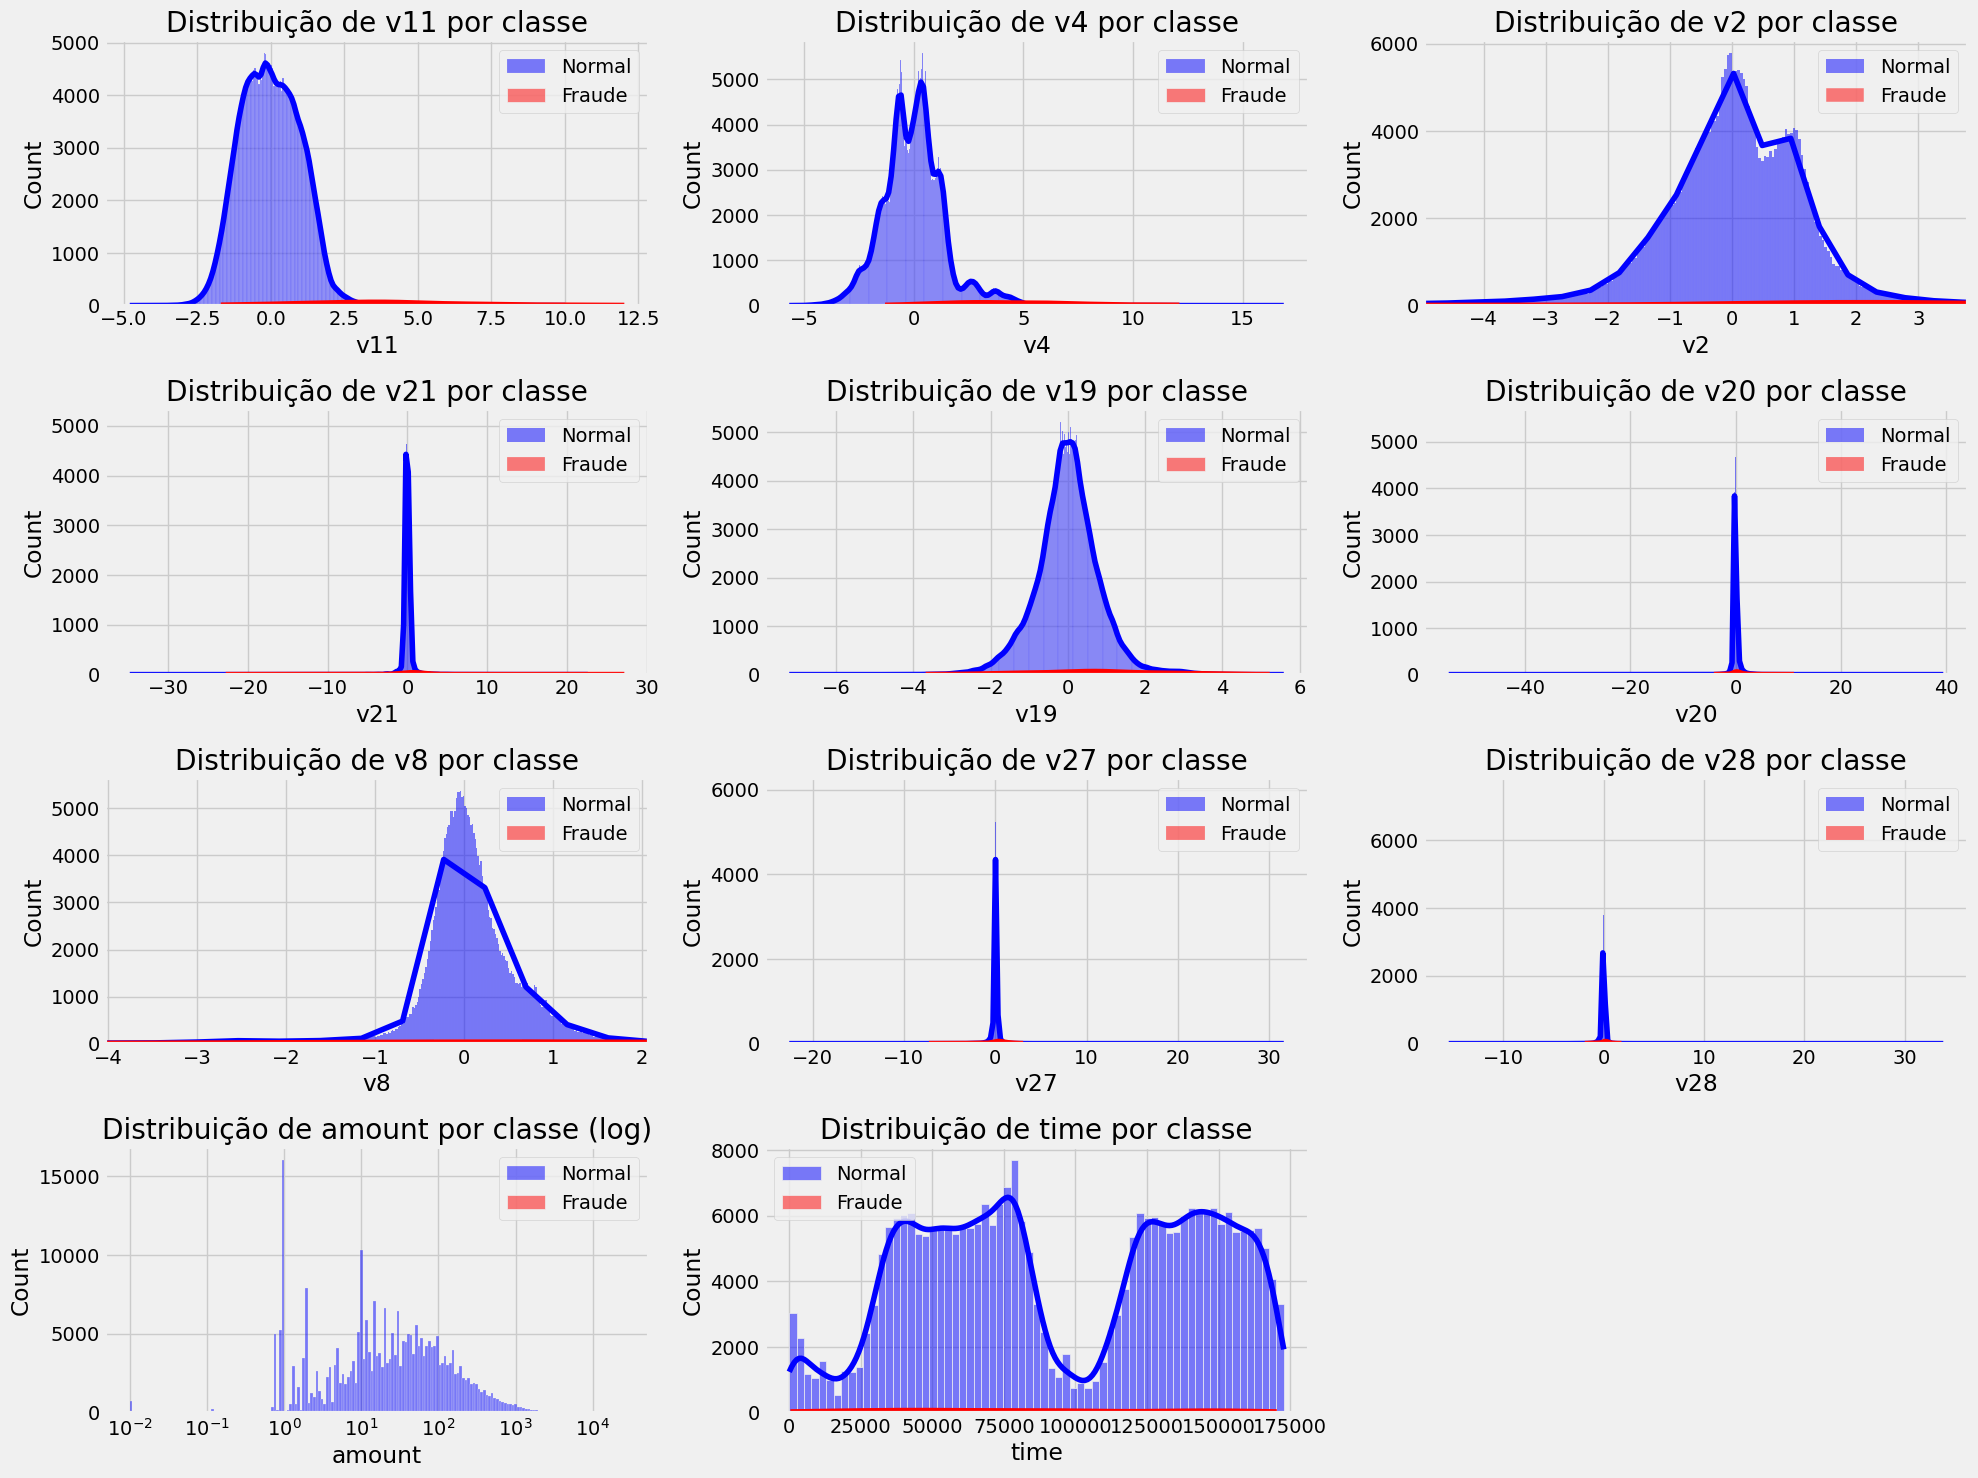

In [75]:
# Selecionar as 10 features mais correlacionadas com 'class'
top_features = correlations_with_target.iloc[1:11].index.tolist()  # excluindo 'class' itself

# Adicionar 'amount' e 'time' para visualização
# 'amount' e 'time' são importantes para a análise de fraudes
features_to_plot = top_features + ['amount', 'time']
features_to_plot = list(dict.fromkeys(features_to_plot))  # Remover possíveis duplicatas

# Visualizar distribuições separadas por classe com melhorias
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i+1)
    
    # Tratamento especial para amount (devido à assimetria)
    if feature == 'amount':
        plt.xscale('log')  # Usar escala logarítmica para amount
        sns.histplot(df[df['class']==0][feature], color='blue', alpha=0.5, label='Normal', kde=True, log_scale=True)
        sns.histplot(df[df['class']==1][feature], color='red', alpha=0.5, label='Fraude', kde=True, log_scale=True)
        plt.title(f'Distribuição de {feature} por classe (log)')
    else:
        sns.histplot(df[df['class']==0][feature], color='blue', alpha=0.5, label='Normal', kde=True)
        sns.histplot(df[df['class']==1][feature], color='red', alpha=0.5, label='Fraude', kde=True)
        plt.title(f'Distribuição de {feature} por classe')
    
    plt.legend()
    
    # Ajustar os limites dos eixos para melhor visualização (opcional)
    if feature in ['v2', 'v8']:  # Variáveis com outliers extremos
        q1, q99 = df[feature].quantile([0.01, 0.99])
        plt.xlim(q1, q99)  # Limitar aos percentis 1% e 99%

plt.tight_layout()
plt.show()

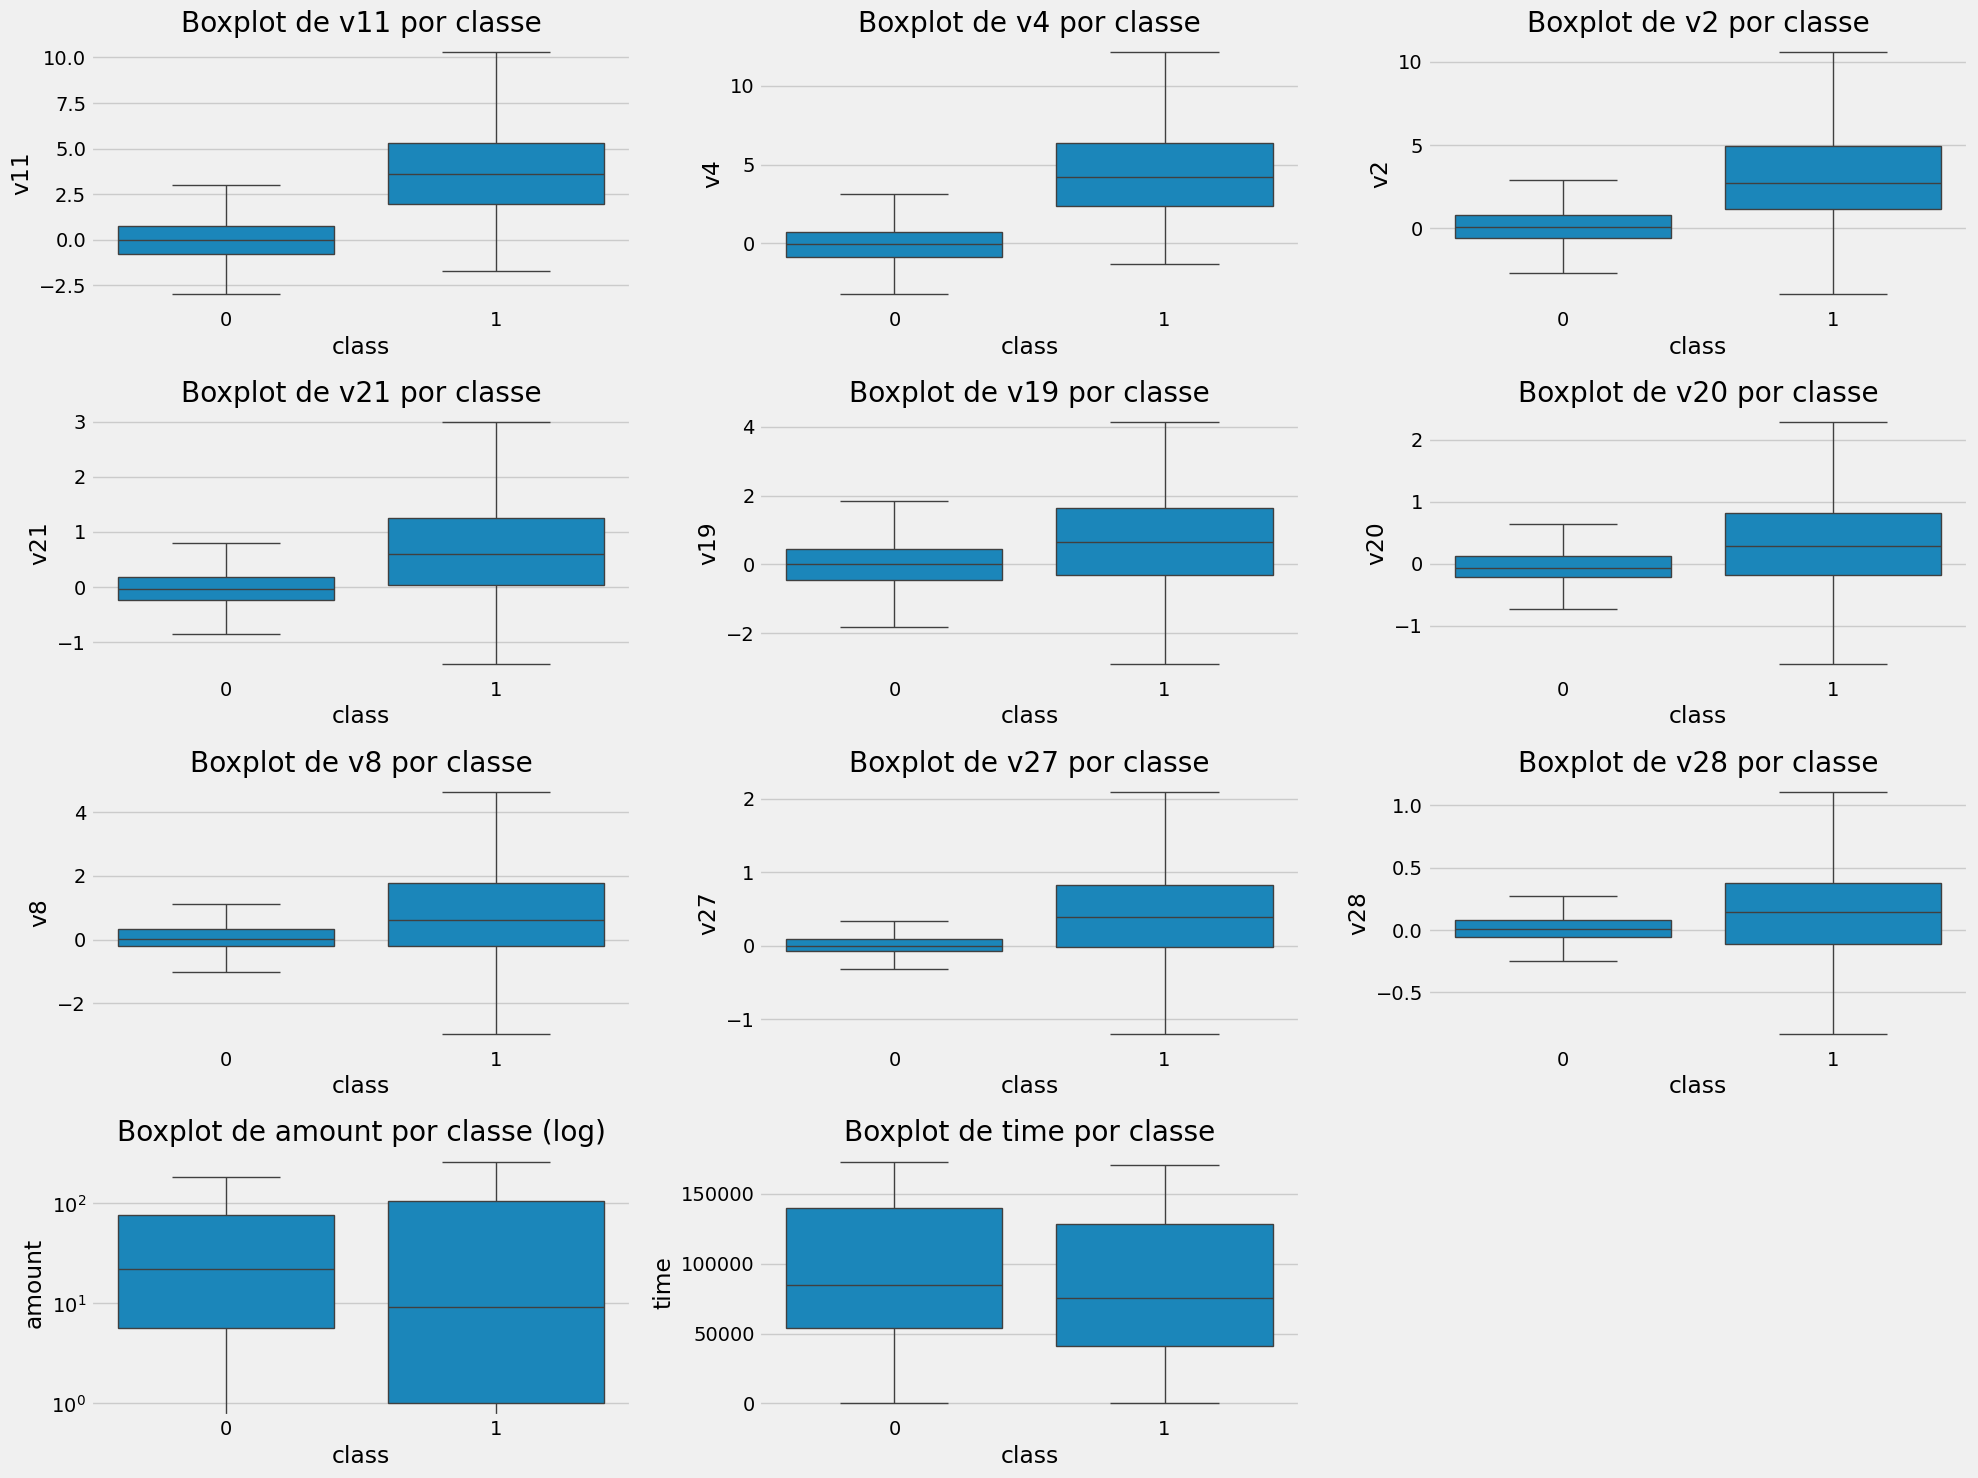

In [76]:
# Boxplots das features principais separadas por classe (corrigido)
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i+1)
    
    # Ajustar visualização de boxplot com menor sensibilidade a outliers
    sns.boxplot(x='class', y=feature, data=df, showfliers=False)  # Remove outliers extremos
    plt.title(f'Boxplot de {feature} por classe')
    
    # Adicionar violinplot para melhor visualização da distribuição (opcional)
    if feature == 'amount':
        plt.yscale('log')  # Usar escala logarítmica para amount
        plt.title(f'Boxplot de {feature} por classe (log)')

plt.tight_layout()
plt.show()

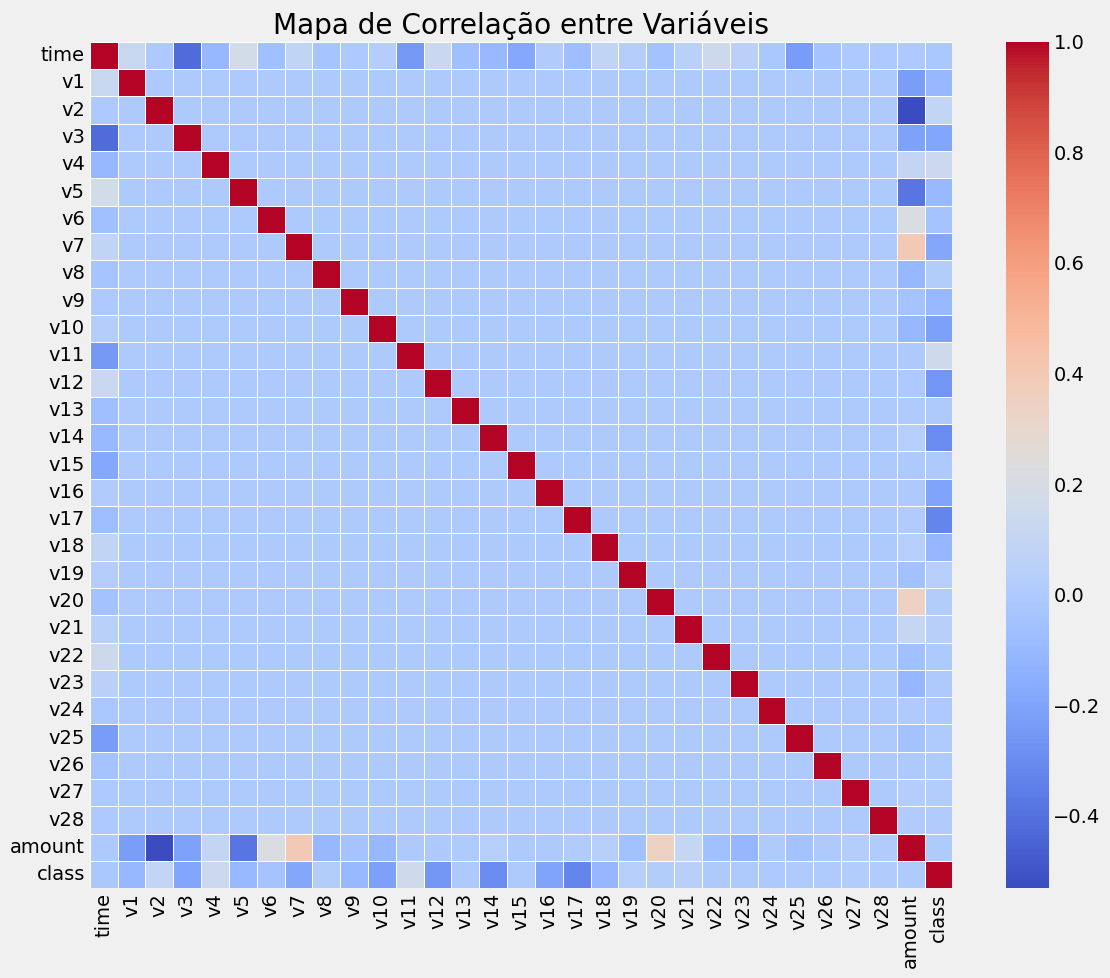

In [77]:
# Verificando correlação entre variáveis
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Correlação entre Variáveis')
plt.tight_layout()
plt.show()


# Resumo da Análise Exploratória: 

## Características do Dataset
| Aspecto | Informação |
|---------|------------|
| Total de transações | 284.807 |
| Features | 31 (time, v1-v28, amount, class) |
| Valores nulos | Nenhum |
| Classe normal (0) | 284.315 (99,83%) |
| Classe fraude (1) | 492 (0,17%) |
| Valor médio transações | 88,35 |
| Maior transação | 25.691,16 |

## Top 5 Features Correlacionadas com Fraude
| Feature | Correlação |
|---------|------------|
| v11 | 0,155 |
| v4 | 0,133 |
| v2 | 0,091 |
| v21 | 0,040 |
| v19 | 0,035 |

## Principais Observações
- **Desbalanceamento severo**: apenas 0,17% das transações são fraudulentas
- **Dados pré-processados**: features v1-v28 já normalizadas por PCA
- **Correlações baixas**: nenhuma feature isolada é forte preditora de fraude
- **Diferenças visuais**: v11, v4 e v2 mostram distribuições distintas entre classes
- **Valor da transação**: baixa correlação com fraude (0,0056)
- **Necessidades para modelagem**: técnicas para lidar com desbalanceamento e métricas apropriadas (não usar acurácia)

# 2. PREPARAÇÃO E ENGENHARIA DE ATRIBUTOS

In [78]:
# Removendo outliers usando o método IQR (Interquartile Range)
def remove_outliers_iqr(df, columns, k=3):
    df_cleaned = df.copy()
    rows_to_remove = set()  # Conjunto para evitar duplicatas
    outliers_by_column = {}
    
    for col in columns:
        q1 = df_cleaned[col].quantile(0.25)
        q3 = df_cleaned[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        
        # Identificar outliers separados por classe
        mask_outliers = (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
        normal_outliers = df_cleaned[mask_outliers & (df_cleaned['class'] == 0)]
        fraud_outliers = df_cleaned[mask_outliers & (df_cleaned['class'] == 1)]
        
        # Armazenar estatísticas por coluna
        outliers_by_column[col] = {
            'total': mask_outliers.sum(),
            'normais': len(normal_outliers),
            'fraudes': len(fraud_outliers)
        }
        
        # Coletar índices de transações normais com outliers para remoção
        if len(normal_outliers) > 0:
            rows_to_remove.update(normal_outliers.index)
    
    # Remover as transações identificadas
    df_cleaned = df_cleaned.drop(index=list(rows_to_remove))
    
    # Exibir estatísticas
    print("\nEstatísticas de outliers por coluna:")
    for col, stats in outliers_by_column.items():
        print(f"  {col}: {stats['total']} outliers ({stats['normais']} normais, {stats['fraudes']} fraudes)")
    
    print(f"\nTotal de transações removidas: {len(rows_to_remove)} de {len(df)} ({len(rows_to_remove)/len(df)*100:.2f}%)")
    print(f"Dimensões após remoção: {df_cleaned.shape}")
    
    return df_cleaned

In [79]:
# Selecionar colunas relevantes para remoção de outliers usando as features mais correlacionadas
cols_to_check = top_features[:10] + ['amount']  # As 5 principais features + amount
print(f"Features selecionadas para detecção de outliers: {cols_to_check}")
df_cleaned = remove_outliers_iqr(df, cols_to_check)
print(f"Dimensões após remoção de outliers: {df_cleaned.shape}")

# Transformações de tempo mais apropriadas para segundos relativos
if 'time' in df_cleaned.columns:
    # 1. Normalizar o tempo (para facilitar a aprendizagem do modelo)
    df_cleaned['time_normalized'] = df_cleaned['time'] / df_cleaned['time'].max()
    
    # 2. Extrair padrões cíclicos diários (se os dados abrangem múltiplos dias)
    # Assumindo que a primeira transação ocorreu em um momento desconhecido
    seconds_in_day = 86400  # 24 * 60 * 60
    df_cleaned['time_day_cycle'] = (df_cleaned['time'] % seconds_in_day) / seconds_in_day
    
    # 3. Extrair característica de "dias decorridos" se relevante
    df_cleaned['days_elapsed'] = df_cleaned['time'] // seconds_in_day
    
    print(f"Intervalo de tempo coberto: {df_cleaned['time'].max() / seconds_in_day:.1f} dias")

# Criar atributos de interação entre as features mais correlacionadas
# Usando as top 3 features identificadas: v11, v4, v2
df_cleaned['v11_v4'] = df_cleaned['v11'] * df_cleaned['v4']  # Top 1 e Top 2
df_cleaned['v11_v2'] = df_cleaned['v11'] * df_cleaned['v2']  # Top 1 e Top 3
df_cleaned['v4_v2'] = df_cleaned['v4'] * df_cleaned['v2']    # Top 2 e Top 3

Features selecionadas para detecção de outliers: ['v11', 'v4', 'v2', 'v21', 'v19', 'v20', 'v8', 'v27', 'v28', 'amount', 'amount']

Estatísticas de outliers por coluna:
  v11: 154 outliers (26 normais, 128 fraudes)
  v4: 479 outliers (305 normais, 174 fraudes)
  v2: 4453 outliers (4324 normais, 129 fraudes)
  v21: 6934 outliers (6791 normais, 143 fraudes)
  v19: 628 outliers (597 normais, 31 fraudes)
  v20: 13385 outliers (13268 normais, 117 fraudes)
  v8: 11285 outliers (11113 normais, 172 fraudes)
  v27: 16524 outliers (16277 normais, 247 fraudes)
  v28: 12573 outliers (12419 normais, 154 fraudes)
  amount: 18941 outliers (18876 normais, 65 fraudes)

Total de transações removidas: 46192 de 284807 (16.22%)
Dimensões após remoção: (238615, 31)
Dimensões após remoção de outliers: (238615, 31)
Intervalo de tempo coberto: 2.0 dias


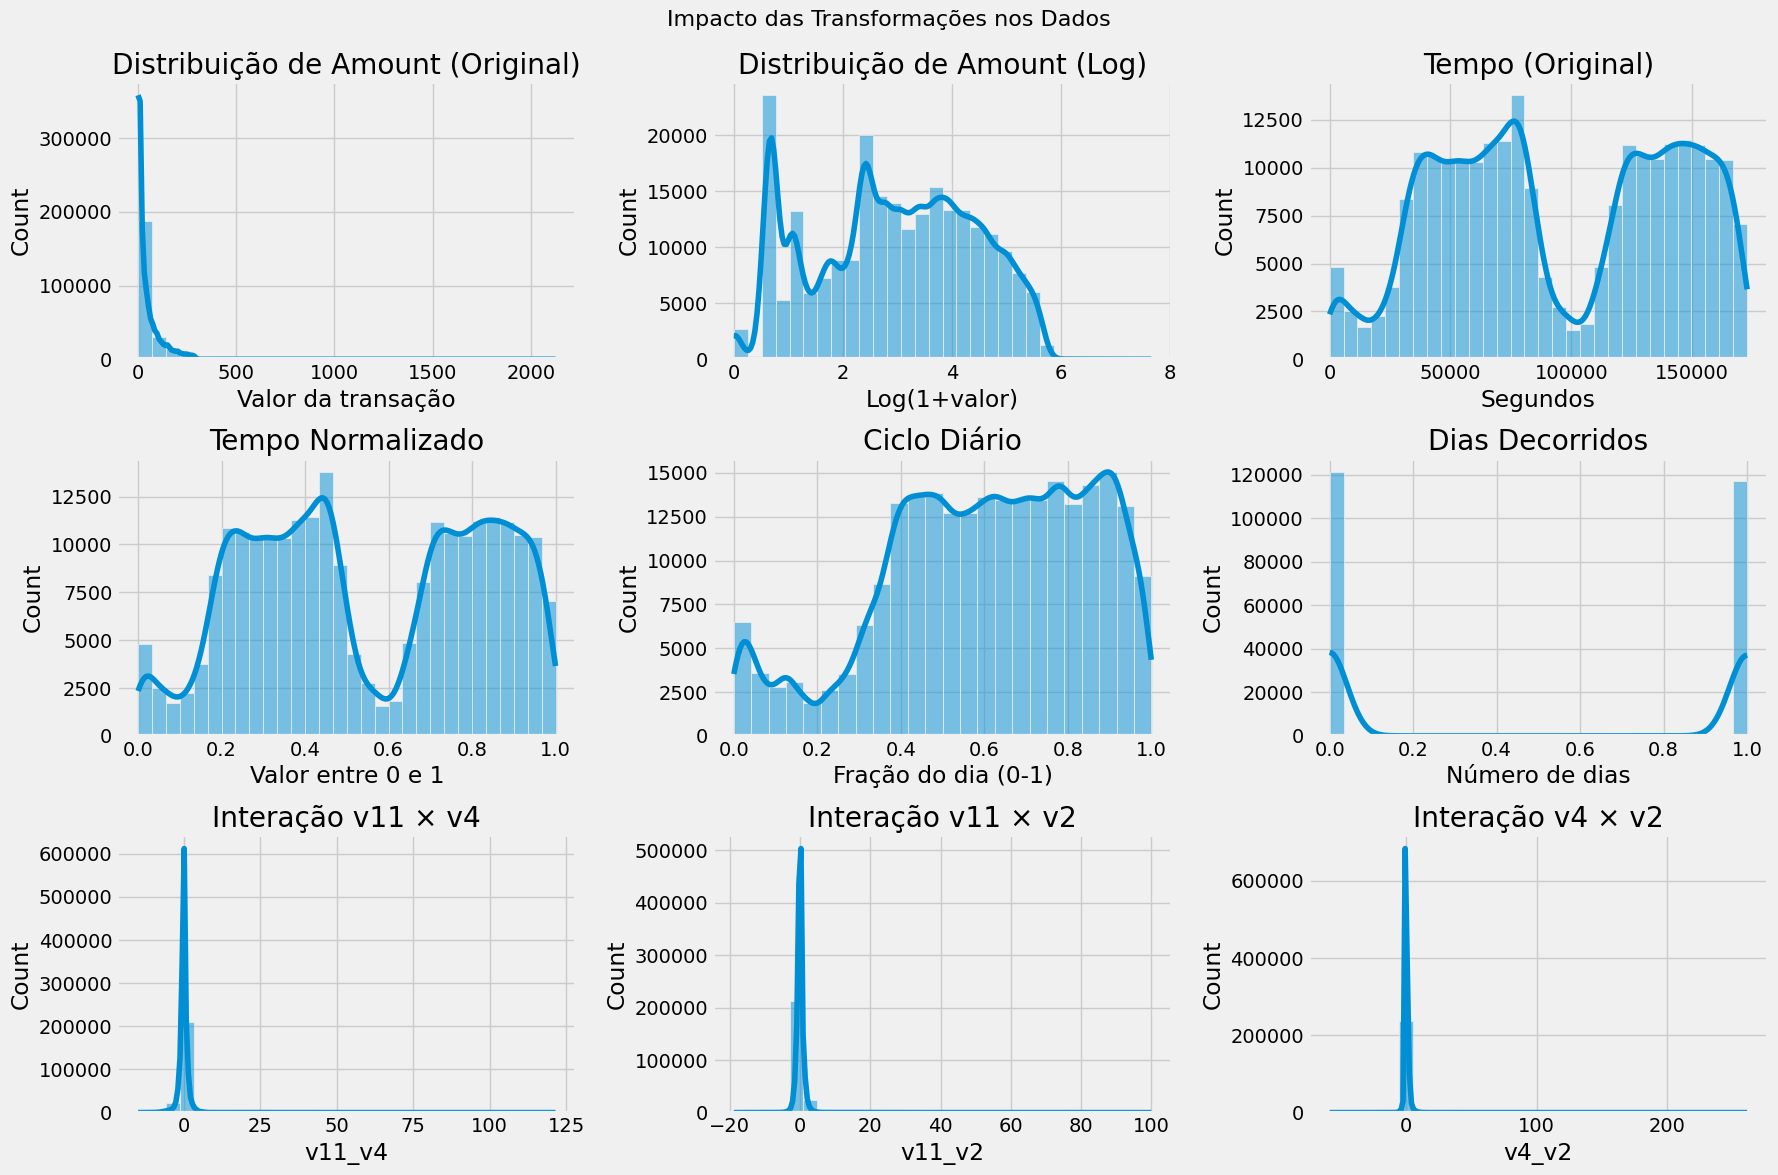

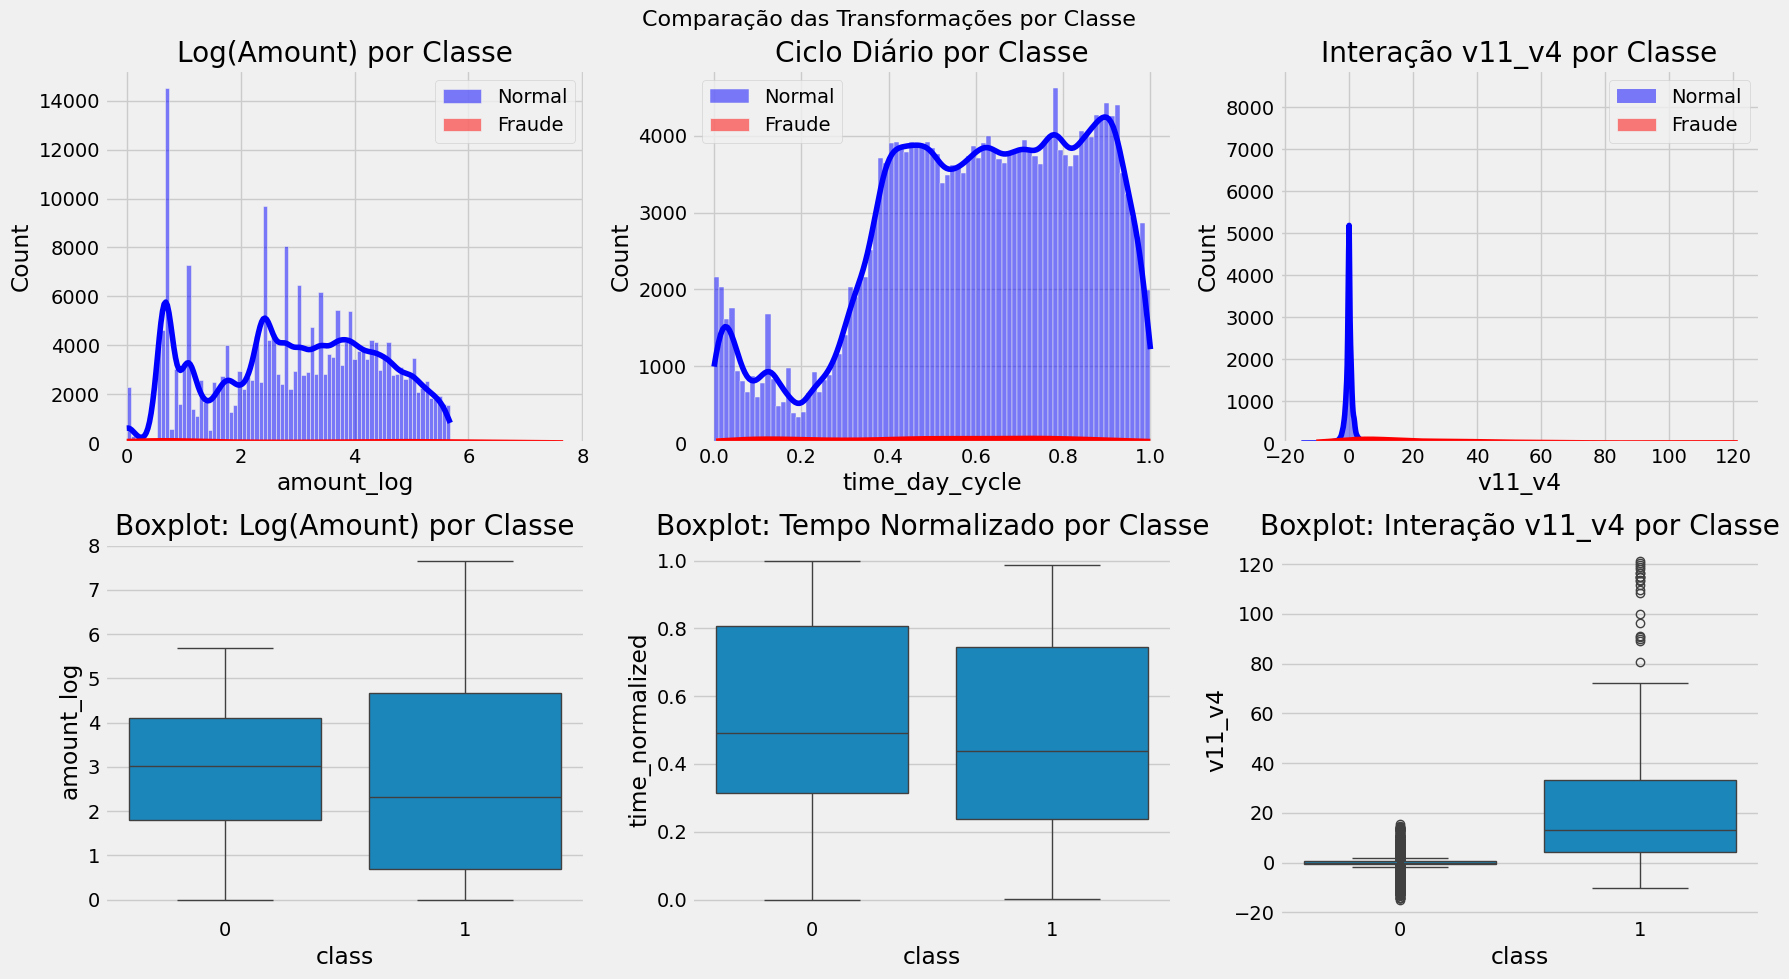

In [80]:
# Adicionar transformação logarítmica para amount (que estava faltando)
df_cleaned['amount_log'] = np.log1p(df_cleaned['amount'])  # log(1+x) para evitar problemas com zeros

# Visualizar impacto das transformações com visualizações organizadas por categoria
plt.figure(figsize=(18, 12))

# Grupo 1: Transformações monetárias
plt.subplot(3, 3, 1)
sns.histplot(df_cleaned['amount'], bins=30, kde=True)
plt.title('Distribuição de Amount (Original)')
plt.xlabel('Valor da transação')

plt.subplot(3, 3, 2)
sns.histplot(df_cleaned['amount_log'], bins=30, kde=True)
plt.title('Distribuição de Amount (Log)')
plt.xlabel('Log(1+valor)')

# Grupo 2: Transformações temporais
plt.subplot(3, 3, 3)
sns.histplot(df_cleaned['time'], bins=30, kde=True)
plt.title('Tempo (Original)')
plt.xlabel('Segundos')

plt.subplot(3, 3, 4)
sns.histplot(df_cleaned['time_normalized'], bins=30, kde=True)
plt.title('Tempo Normalizado')
plt.xlabel('Valor entre 0 e 1')

plt.subplot(3, 3, 5)
sns.histplot(df_cleaned['time_day_cycle'], bins=24, kde=True)
plt.title('Ciclo Diário')
plt.xlabel('Fração do dia (0-1)')

plt.subplot(3, 3, 6)
sns.histplot(df_cleaned['days_elapsed'], bins=30, kde=True)
plt.title('Dias Decorridos')
plt.xlabel('Número de dias')

# Grupo 3: Features de interação criadas
plt.subplot(3, 3, 7)
sns.histplot(df_cleaned['v11_v4'], bins=30, kde=True)
plt.title('Interação v11 × v4')

plt.subplot(3, 3, 8)
sns.histplot(df_cleaned['v11_v2'], bins=30, kde=True)
plt.title('Interação v11 × v2')

plt.subplot(3, 3, 9)
sns.histplot(df_cleaned['v4_v2'], bins=30, kde=True)
plt.title('Interação v4 × v2')

plt.tight_layout()
plt.suptitle('Impacto das Transformações nos Dados', fontsize=16)
plt.subplots_adjust(top=0.92)  # Ajustar para que o título não sobreponha os subplots
plt.show()

# Visualizar a diferença nas distribuições entre transações normais e fraudulentas
# para algumas das transformações mais importantes
plt.figure(figsize=(18, 10))

# Amount original e transformada
plt.subplot(2, 3, 1)
sns.histplot(df_cleaned[df_cleaned['class']==0]['amount_log'], 
             color='blue', label='Normal', kde=True, alpha=0.5)
sns.histplot(df_cleaned[df_cleaned['class']==1]['amount_log'], 
             color='red', label='Fraude', kde=True, alpha=0.5)
plt.title('Log(Amount) por Classe')
plt.legend()

# Ciclo diário
plt.subplot(2, 3, 2)
sns.histplot(df_cleaned[df_cleaned['class']==0]['time_day_cycle'], 
             color='blue', label='Normal', kde=True, alpha=0.5)
sns.histplot(df_cleaned[df_cleaned['class']==1]['time_day_cycle'], 
             color='red', label='Fraude', kde=True, alpha=0.5)
plt.title('Ciclo Diário por Classe')
plt.legend()

# Feature de interação
plt.subplot(2, 3, 3)
sns.histplot(df_cleaned[df_cleaned['class']==0]['v11_v4'], 
             color='blue', label='Normal', kde=True, alpha=0.5)
sns.histplot(df_cleaned[df_cleaned['class']==1]['v11_v4'], 
             color='red', label='Fraude', kde=True, alpha=0.5)
plt.title('Interação v11_v4 por Classe')
plt.legend()

plt.subplot(2, 3, 4)
sns.boxplot(x='class', y='amount_log', data=df_cleaned)
plt.title('Boxplot: Log(Amount) por Classe')

plt.subplot(2, 3, 5)
sns.boxplot(x='class', y='time_normalized', data=df_cleaned)
plt.title('Boxplot: Tempo Normalizado por Classe')

plt.subplot(2, 3, 6)
sns.boxplot(x='class', y='v11_v4', data=df_cleaned)
plt.title('Boxplot: Interação v11_v4 por Classe')

plt.tight_layout()
plt.suptitle('Comparação das Transformações por Classe', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

Os resultados mostram o quanto cada feature está correlacionada com a ocorrência de fraude. Aqui está o que podemos interpretar:

## Principais Observações
- **Correlações Baixas:** A feature com maior correlação (v11) tem apenas 0,15, indicando que nenhuma variável sozinha é forte preditora de fraude
- **Top 3 Features:** v11, v4 e v2 se destacam com correlações significativamente maiores que as demais
- **Valor Monetário:** Surpreendentemente, o valor da transação (amount) tem correlação muito baixa (0,005), contrariando a intuição de que valores anormais indicariam fraude
- **Features PCA:** Como essas variáveis v1-v28 são resultados de PCA, representam combinações das características originais das transações

## Implicações para o Modelo
- **Necessidade de Combinações:** Como nenhuma feature isolada é forte preditora, a criação de features de interação (como v11_v4) foi uma escolha acertada
- **Foco nas Top Features:** Priorizar v11, v4 e v2 na engenharia de atributos maximiza o poder discriminativo
- **Importância da Engenharia:** A baixa correlação individual reforça a necessidade das transformações e criação de novas features que realizamos

In [81]:
# Divisão em features (X) e target (y)
X = df_cleaned.drop('class', axis=1)
y = df_cleaned['class']

# Divisão em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print(f"\nDimensões dos conjuntos de treino e teste:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Dimensões dos conjuntos de treino e teste:
X_train: (190892, 37), y_train: (190892,)
X_test: (47723, 37), y_test: (47723,)


In [82]:
# Verificar os tipos de dados nas colunas para diagnóstico
print("Tipos de dados nas colunas:")
print(X_train.dtypes)

# Identificar colunas com tipo Interval
cols_with_interval = []
for col in X_train.columns:
    if 'interval' in str(X_train[col].dtype).lower() or X_train[col].apply(lambda x: isinstance(x, pd.Interval)).any():
        cols_with_interval.append(col)

print(f"\nColunas com objetos Interval: {cols_with_interval}")

Tipos de dados nas colunas:
time               float64
v1                 float64
v2                 float64
v3                 float64
v4                 float64
v5                 float64
v6                 float64
v7                 float64
v8                 float64
v9                 float64
v10                float64
v11                float64
v12                float64
v13                float64
v14                float64
v15                float64
v16                float64
v17                float64
v18                float64
v19                float64
v20                float64
v21                float64
v22                float64
v23                float64
v24                float64
v25                float64
v26                float64
v27                float64
v28                float64
amount             float64
time_normalized    float64
time_day_cycle     float64
days_elapsed       float64
v11_v4             float64
v11_v2             float64
v4_v2              float64


In [83]:
# Converter a coluna time_bin (categoria com intervalos) para valores numéricos
if 'time_bin' in X_train.columns:
    # Extrair o ponto médio de cada intervalo
    X_train['time_bin'] = X_train['time_bin'].apply(lambda x: x.mid if isinstance(x, pd.Interval) else x)
    X_test['time_bin'] = X_test['time_bin'].apply(lambda x: x.mid if isinstance(x, pd.Interval) else x)
    
    print("Coluna time_bin convertida para valores numéricos (ponto médio do intervalo)")

# Agora é possível aplicar o StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalização concluída com sucesso!")

Normalização concluída com sucesso!


In [84]:
# Normalização/padronização dos dados com StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Média das features após normalização: -0.000000 (ideal: ~0)
Desvio padrão após normalização: 1.000000 (ideal: ~1)


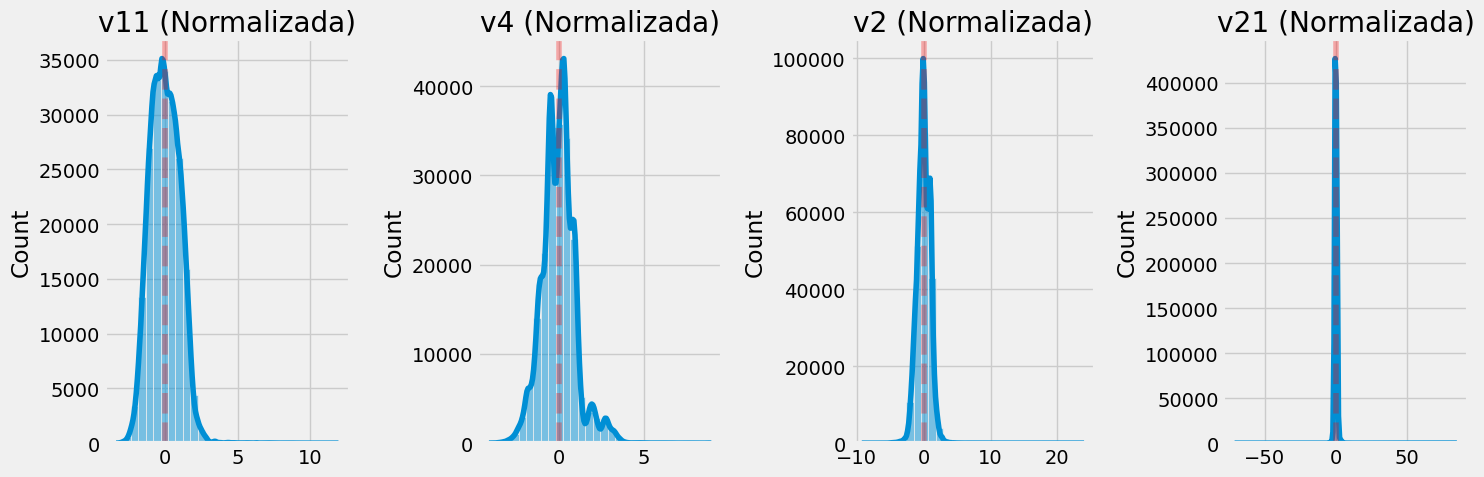

In [85]:
# Verificação simples da distribuição após normalização
# Selecionar features importantes para visualização
important_features = top_features[:4]  # Usar as 4 features mais importantes
feature_indices = [X_train.columns.get_loc(feature) for feature in important_features]

# Verificar estatísticas básicas da normalização
means = np.mean(X_train_scaled, axis=0)
stds = np.std(X_train_scaled, axis=0)
print(f"Média das features após normalização: {means.mean():.6f} (ideal: ~0)")
print(f"Desvio padrão após normalização: {stds.mean():.6f} (ideal: ~1)")

# Visualizar as 4 features mais importantes
plt.figure(figsize=(15, 5))
for i, idx in enumerate(feature_indices):
    plt.subplot(1, 4, i+1)
    sns.histplot(X_train_scaled[:, idx], bins=30, kde=True)
    plt.title(f'{important_features[i]} (Normalizada)')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.3)  # linha em x=0

plt.tight_layout()
plt.show()

# 3. IMPLEMENTAÇÃO DO MODELO EM PYTORCH

In [86]:
# Definição da classe Architecture conforme fornecido em week05c.ipynb
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                
            # Imprimir progresso a cada 10 épocas
            if (epoch + 1) % 10 == 0:
                print(f'Época {epoch+1}/{n_epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes a Numpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        with torch.no_grad():
            y_hat_tensor = self.model(x_tensor.to(self.device))
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

In [87]:
# Preparação dos dados para o PyTorch
# Aplicar undersampling controlado para lidar com desbalanceamento

def create_balanced_loaders(X_train, X_test, y_train, y_test, normal_fraud_ratio=10):
    """Cria dataloaders com balanceamento através de undersampling controlado"""
    
    # Obter índices das classes
    normal_indices = np.where(y_train == 0)[0]
    fraud_indices = np.where(y_train == 1)[0]
    
    n_frauds = len(fraud_indices)
    n_normal = len(normal_indices)
    
    print(f"\nDistribuição original: {n_normal} normais, {n_frauds} fraudes")
    print(f"Proporção original: {n_normal/n_frauds:.2f}:1")
    
    # Determinar quantas amostras normais manter
    n_normal_samples = min(n_frauds * normal_fraud_ratio, n_normal)
    
    # Selecionar amostra aleatória de transações normais
    np.random.seed(42)  # Para reprodutibilidade
    normal_indices_sampled = np.random.choice(normal_indices, n_normal_samples, replace=False)
    
    # Combinar índices
    sampled_indices = np.concatenate([normal_indices_sampled, fraud_indices])
    np.random.shuffle(sampled_indices)  # Misturar os índices
    
    # Criar subconjunto balanceado
    X_train_balanced = X_train[sampled_indices]
    y_train_balanced = y_train[sampled_indices]
    
    print(f"Distribuição após undersampling: {n_normal_samples} normais, {n_frauds} fraudes")
    print(f"Proporção após undersampling: {n_normal_samples/n_frauds:.2f}:1")
    print(f"Total de amostras de treinamento: {len(y_train_balanced)}")
    
    # Conversão para tensores PyTorch
    X_train_tensor = torch.FloatTensor(X_train_balanced)
    y_train_tensor = torch.FloatTensor(y_train_balanced.reshape(-1, 1))
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test.reshape(-1, 1))
    
    # Criação dos datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Criação dos dataloaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE
    )
    
    return train_loader, test_loader

# Criar os dataloaders balanceados
train_loader, test_loader = create_balanced_loaders(
    X_train_scaled, X_test_scaled, y_train.values, y_test.values, normal_fraud_ratio=10
)


Distribuição original: 190499 normais, 393 fraudes
Proporção original: 484.73:1
Distribuição após undersampling: 3930 normais, 393 fraudes
Proporção após undersampling: 10.00:1
Total de amostras de treinamento: 4323


# 4. TREINAMENTO DO MODELO

In [99]:
# Definir modelo, perda e otimizador
input_dim = X_train_scaled.shape[1]  # Número de features

# Definir o modelo de regressão logística (uma única camada linear)
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(input_dim, 1))

# Calcular peso para a classe positiva (fraude) para lidar com desbalanceamento
n_samples = len(y_train)
n_frauds = np.sum(y_train)
n_normal = n_samples - n_frauds
pos_weight = torch.tensor([n_normal / n_frauds]).to(device)

print(f"\nCalculando peso para classe positiva (fraude):")
print(f"Total de amostras: {n_samples}")
print(f"Amostras normais: {n_normal}")
print(f"Amostras de fraude: {n_frauds}")
print(f"Proporção: {n_normal / n_frauds:.2f}:1")
print(f"Peso aplicado à classe positiva: {pos_weight.item():.2f}\n")

# Definir função de perda com peso para classe minoritária
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Definir otimizador SGD (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)



Calculando peso para classe positiva (fraude):
Total de amostras: 190892
Amostras normais: 190499
Amostras de fraude: 393
Proporção: 484.73:1
Peso aplicado à classe positiva: 484.73



In [100]:
# Inicializar a arquitetura de treinamento
arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, test_loader)

# Treinar o modelo
print(f"Iniciando treinamento por {NUM_EPOCHS} épocas...")
arch.train(NUM_EPOCHS)
print("Treinamento concluído!")

Iniciando treinamento por 40 épocas...
Época 10/40, Loss: 2.9075, Val Loss: 3.1357
Época 20/40, Loss: 2.0540, Val Loss: 2.2211
Época 30/40, Loss: 1.6487, Val Loss: 1.8773
Época 40/40, Loss: 1.3905, Val Loss: 1.7368
Treinamento concluído!


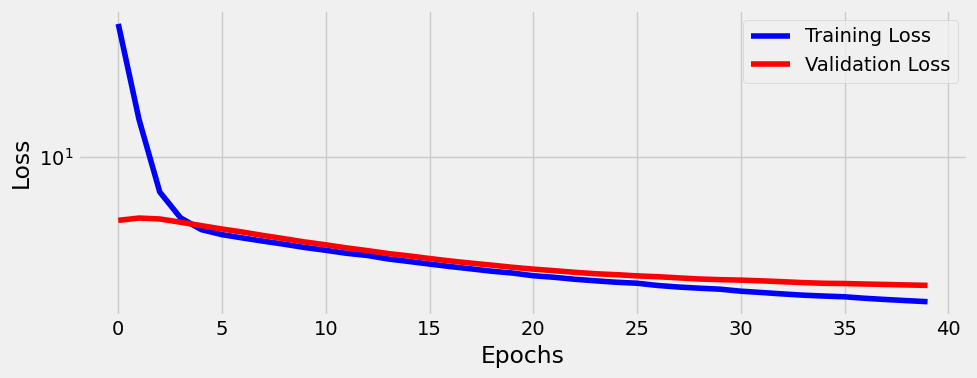

In [101]:
# Plotar evolução da perda
loss_fig = arch.plot_losses()
plt.show()

# 5. AVALIAÇÃO DO MODELO

In [104]:
# Adicione estas funções no início da célula, antes de usá-las
def precision_recall(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall

def tpr_fpr(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tpr, fpr

Matriz de confusão com threshold 0.5:
[[35118 12506]
 [    6    93]]
Precisão: 0.0074, Recall: 0.9394
Acurácia: 0.7378
TPR: 0.9394, FPR: 0.2626
AUC-ROC: 0.9509


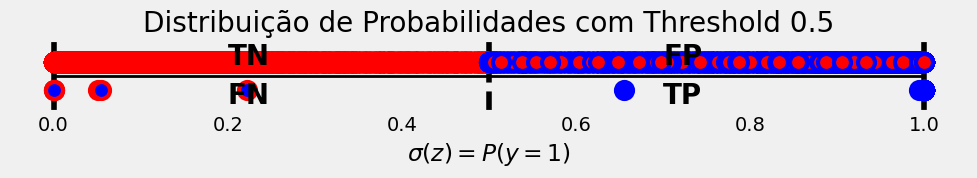

In [ ]:
# Obter as predições do modelo nos dados de teste
logits = arch.predict(X_test_scaled)

# Converter os logits para probabilidades usando a função sigmoid
y_pred_proba = sigmoid(logits).squeeze()

# Calcular a matriz de confusão com threshold padrão de 0.5
cm_thresh50 = confusion_matrix(y_test, (y_pred_proba >= 0.5))
print("Matriz de confusão com threshold 0.5:")
print(cm_thresh50)

# Agora esta função já está definida
precision, recall = precision_recall(cm_thresh50)
print(f"Precisão: {precision:.4f}, Recall: {recall:.4f}")

# Calcular acurácia
accuracy = accuracy_score(y_test, (y_pred_proba >= 0.5))
print(f"Acurácia: {accuracy:.4f}")

# Calcular TPR e FPR
tpr, fpr = tpr_fpr(cm_thresh50)
print(f"TPR: {tpr:.4f}, FPR: {fpr:.4f}")

# Calcular AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_score:.4f}")

# Visualizar resultados como no week05c
# Adicionando função para visualizar as probabilidades em uma linha
def figure10(y, probabilities, threshold=0.5, shift=0.04, annot=True):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    
    # Configurações do plot
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)
    
    # Identificar os diferentes tipos de classificação
    tn = (y == 0) & (probabilities < threshold)
    fn = (y == 0) & (probabilities >= threshold)
    tp = (y == 1) & (probabilities >= threshold)
    fp = (y == 1) & (probabilities < threshold)
    
    # Desenhar o threshold
    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')
    
    # Desenhar os pontos
    colors = ['#FF0000', '#0000FF']  # Vermelho e azul
    ax.scatter(probabilities[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probabilities[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probabilities[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probabilities[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    
    ax.set_xlabel(r'$\sigma(z) = P(y=1)$')
    ax.set_title(f'Threshold = {threshold}')
    
    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)
    
    fig.tight_layout()
    return fig

# Função para calcular os valores a partir da matriz de confusão
def precision_recall(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall

def tpr_fpr(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tpr, fpr

# Visualizar a linha de probabilidades
fig = figure10(y_test, y_pred_proba, threshold=0.5, shift=0.04, annot=True)
plt.title('Distribuição de Probabilidades com Threshold 0.5')
plt.show()

In [112]:
# Adicionar cálculo de F1-score e especificidade
def f1_score_manual(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def specificity(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Calcular F1-score e especificidade
f1 = f1_score_manual(precision, recall)
spec = specificity(cm_thresh50)

print(f"F1-Score: {f1:.4f}")
print(f"Especificidade: {spec:.4f}")

F1-Score: 0.0146
Especificidade: 0.7374


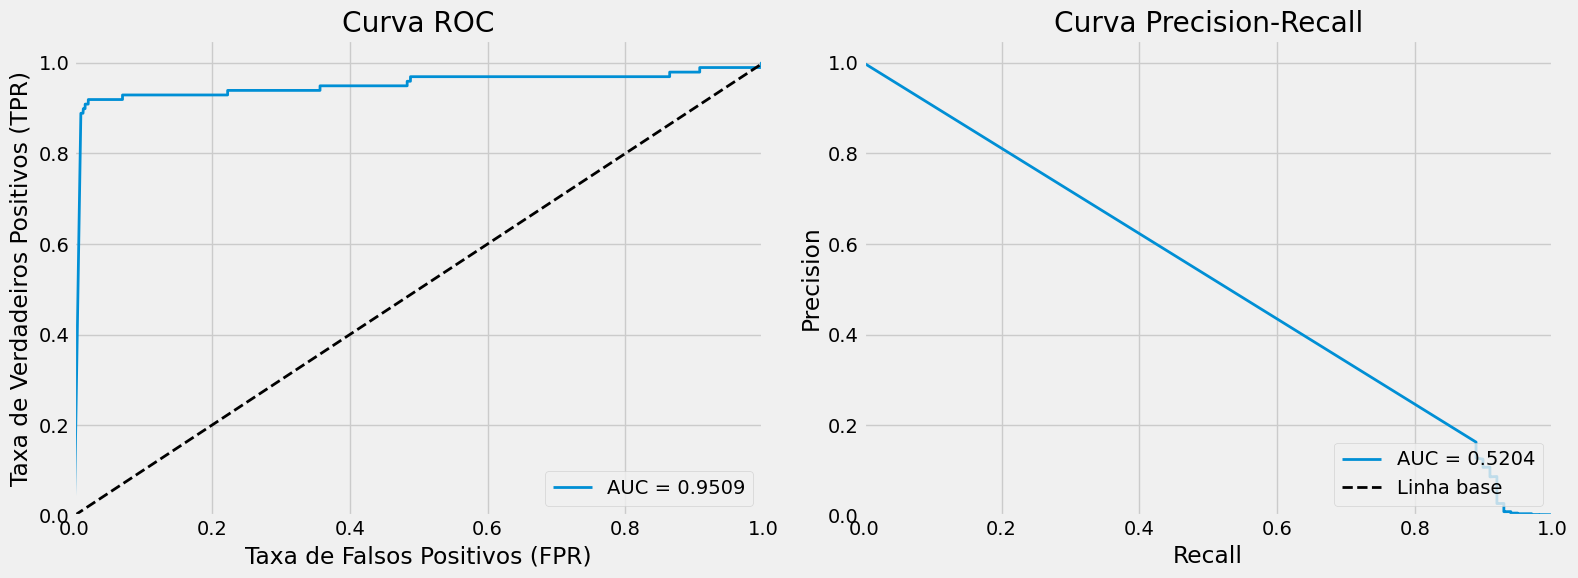

In [113]:
# Visualizar curvas ROC e Precision-Recall
plt.figure(figsize=(16, 6))

# Curva ROC
plt.subplot(1, 2, 1)
fpr_curve, tpr_curve, thresholds_roc = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_curve, tpr_curve, lw=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva Precision-Recall
plt.subplot(1, 2, 2)
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)
plt.plot(recall_curve, precision_curve, lw=2, label=f'AUC = {pr_auc:.4f}')
plt.plot([0, 1], [np.sum(y_test)/len(y_test)] * 2, 'k--', lw=2, label='Linha base')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [119]:
# Encontrar o threshold ótimo para balancear precision e recall
def find_optimal_threshold(y_true, y_proba, metric='f1', thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.02)
    
    best_metric = 0
    best_threshold = 0.5
    best_metrics = {}
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        prec, rec = precision_recall(cm)
        f1 = f1_score_manual(prec, rec)
        tpr, fpr = tpr_fpr(cm)
        spec = specificity(cm)
        acc = accuracy_score(y_true, y_pred)
        
        # Escolher métrica para otimização
        if metric == 'f1':
            current_metric = f1
        elif metric == 'recall':
            current_metric = rec
        elif metric == 'precision':
            current_metric = prec
        else:
            # Usar uma métrica balanceada (média geométrica de TPR e TNR)
            current_metric = np.sqrt(tpr * spec)
        
        if current_metric > best_metric:
            best_metric = current_metric
            best_threshold = threshold
            best_metrics = {
                'threshold': threshold,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'specificity': spec,
                'f1_score': f1,
                'tpr': tpr,
                'fpr': fpr
            }
    
    return best_threshold, best_metrics

# Encontrar threshold ótimo e mostrar resultados
print("\nProcurando threshold ótimo...")
best_threshold, best_metrics = find_optimal_threshold(
    y_test, y_pred_proba, metric='f1', 
    thresholds=np.arange(0.1, 0.9, 0.01)
)


Procurando threshold ótimo...


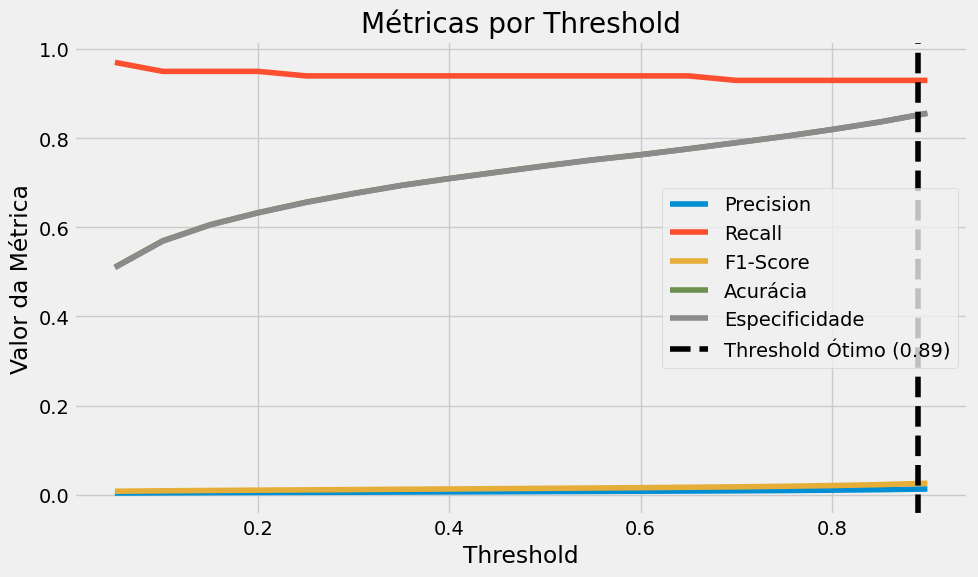

In [121]:
# Visualizar como as métricas variam com o threshold
thresholds = np.arange(0.05, 0.95, 0.05)
metrics_by_threshold = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'specificity': [],
    'f1_score': []
}

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    prec, rec = precision_recall(cm)
    f1 = f1_score_manual(prec, rec)
    spec = specificity(cm)
    acc = accuracy_score(y_test, y_pred)
    
    metrics_by_threshold['threshold'].append(threshold)
    metrics_by_threshold['accuracy'].append(acc)
    metrics_by_threshold['precision'].append(prec)
    metrics_by_threshold['recall'].append(rec)
    metrics_by_threshold['specificity'].append(spec)
    metrics_by_threshold['f1_score'].append(f1)

# Plotar as métricas por threshold
plt.figure(figsize=(10, 6))
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['precision'], label='Precision')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['recall'], label='Recall')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['f1_score'], label='F1-Score')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['accuracy'], label='Acurácia')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['specificity'], label='Especificidade')
plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Threshold Ótimo ({best_threshold:.2f})')

plt.xlabel('Threshold')
plt.ylabel('Valor da Métrica')
plt.title('Métricas por Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. DOCUMENTAÇÃO DOS RESULTADOS

In [123]:
# Exibir os parâmetros do modelo treinado

#print("\nParâmetros do modelo de regressão logística treinado:")
#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(f"{name}: {param.data}")

# Mostrar a equação de regressão logística resultante
# Obter os pesos (coeficientes) e o viés (intercepto)
if hasattr(model, 'linear'):
    weights = model.linear.weight.data.cpu().numpy()[0]
    bias = model.linear.bias.data.cpu().numpy()[0]
    
    print("\nEquação da Regressão Logística:")
    equation = f"z = {bias:.4f}"
    
    for i, w in enumerate(weights):
        sign = "+" if w >= 0 else ""
        equation += f" {sign} {w:.4f}*x{i+1}"
    
    print(equation)
    print("\nProbabilidade de fraude = 1 / (1 + exp(-z))")

# Resumo dos resultados
print("\n" + "="*50)
print("RESUMO DOS RESULTADOS - DETECÇÃO DE FRAUDE EM CARTÃO DE CRÉDITO")
print("="*50)
print("Modelo: Regressão Logística Binária")
print(f"Número de features: {input_dim}")
print(f"Total de amostras: {len(df_cleaned)}")
print(f"Amostras de treino: {len(y_train)}, Amostras de teste: {len(y_test)}")
print(f"Proporção de fraudes: {df_cleaned['class'].mean()*100:.2f}%")
print(f"\nMétricas com threshold ótimo ({best_threshold:.2f}):")
print(f"Acurácia: {best_metrics['accuracy']:.4f}")
print(f"Precisão: {best_metrics['precision']:.4f}")
print(f"Recall (Sensitividade): {best_metrics['recall']:.4f}")
print(f"Especificidade: {best_metrics['specificity']:.4f}")
print(f"F1-Score: {best_metrics['f1_score']:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("="*50)

# Salvar o modelo e o scaler para uso futuro
torch.save(model.state_dict(), "modelo_regressao_logistica.pth")


Equação da Regressão Logística:
z = -2.3480  -0.2776*x1  -4.0426*x2 + 0.8092*x3  -3.9049*x4 + 5.1727*x5 + 0.6086*x6  -0.3456*x7  -6.0499*x8  -5.2580*x9  -1.4999*x10  -5.1211*x11 + 0.4078*x12  -3.5574*x13  -0.4358*x14  -4.6299*x15  -0.9868*x16  -3.8275*x17  -6.2862*x18  -1.6612*x19  -0.0044*x20 + 0.7964*x21  -2.2354*x22 + 2.8610*x23 + 0.9153*x24 + 0.0562*x25 + 0.3785*x26  -0.2750*x27  -0.8276*x28 + 0.4112*x29 + 1.9722*x30  -0.2548*x31 + 0.5564*x32  -0.6575*x33 + 2.4416*x34 + 3.8429*x35 + 3.1294*x36  -2.2634*x37

Probabilidade de fraude = 1 / (1 + exp(-z))

RESUMO DOS RESULTADOS - DETECÇÃO DE FRAUDE EM CARTÃO DE CRÉDITO
Modelo: Regressão Logística Binária
Número de features: 37
Total de amostras: 238615
Amostras de treino: 190892, Amostras de teste: 47723
Proporção de fraudes: 0.21%

Métricas com threshold ótimo (0.89):
Acurácia: 0.8513
Precisão: 0.0128
Recall (Sensitividade): 0.9293
Especificidade: 0.8512
F1-Score: 0.0253
AUC-ROC: 0.9509
